<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/master/10.Interpretability/Kernels_and_Activations_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries and modules**

In [0]:
import numpy as np
import keras.backend as K

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import cifar10

from skimage import io

# GRADCAM

Let's start with a pretrained VGG model

In [2]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

Using TensorFlow backend.


1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
VGG Input shape is defined as 224*224 and because VGG was using fully connected layer, model could not use generic dimension input images.

5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [5]:
model = VGG16(weights="imagenet")

(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
#Picking up a random image from CIFAr-10 dataset
test_img = train_features[100]
#dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
test_img = cv2.resize(test_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(test_img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)





553467904/553467096 [==============================] - 39s 0us/step








1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the final convolutional layer

In [6]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

675


**675 - ImageNet class id for 'Moving Van'**

1. Compute the gradient of the class output value with respect to the feature map
2. Pool the gradients over all the axies leaving out the channel dimension
3. Weigh the output feature map with the computed gradient values

In [0]:
def compute_conv_layer(last_conv_layer):
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  print(pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  return conv_layer_output_value

1. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
2. Normalize the heat map to make the values between 0 and 1

In [10]:
conv_layer_output_value = compute_conv_layer(last_conv_layer)
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


Show the results

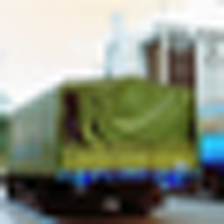

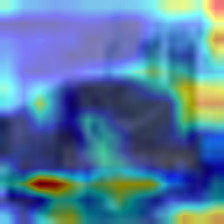

In [13]:
heatmap = cv2.resize(heatmap, (test_img.shape[1], test_img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(test_img, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( test_img)
cv2_imshow(superimposed_img)

### GradCAM at a layer 'block5_conv2' one before 'block5_conv3'

(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


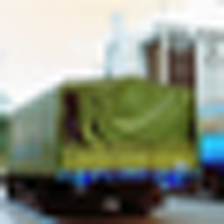

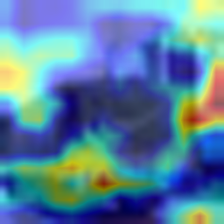

In [14]:
last_conv_layer = model.get_layer("block5_conv2")
conv_layer_output_value = compute_conv_layer(last_conv_layer)
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = cv2.resize(heatmap, (test_img.shape[1], test_img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(test_img, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( test_img)
cv2_imshow(superimposed_img)

### GradCAM at a layer 'block5_conv1' one before 'block5_conv2'

(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


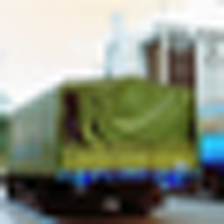

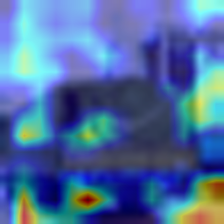

In [15]:
last_conv_layer = model.get_layer("block5_conv1")
conv_layer_output_value = compute_conv_layer(last_conv_layer)
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = cv2.resize(heatmap, (test_img.shape[1], test_img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(test_img, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( test_img)
cv2_imshow(superimposed_img)

### Observations

GradCam results are much clearer with the layer closer to predictions and the background part of the image are not much activated. But in previous layers, we can see the activations are spread across the whole image rather than the wheels of the 'Moving Van'

### Identifying Sunglasses

In [0]:
#ironman_img = cv2.imread('https://github.com/gkdivya/EVA/blob/master/10.Interpretability/assets/TonyStark.jpg')

In [28]:
ironman_img = cv2.imread('/content/TonyStark.jpg')
ironman_img = cv2.resize(ironman_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(ironman_img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)


837


**837 - ImageNet class id for 'sunglasses, dark glasses, shades'**

(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


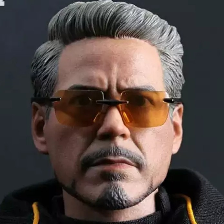

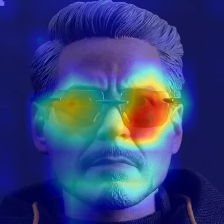

In [30]:
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")
conv_layer_output_value = compute_conv_layer(last_conv_layer)
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = cv2.resize(heatmap, (ironman_img.shape[1], ironman_img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(ironman_img, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( ironman_img)
cv2_imshow(superimposed_img)

### Observations

GradCam - activations show the sunglasses in the Tony stark image

## Second Part 

*   Refer to this paper: https://arxiv.org/pdf/1701.03056.pdf (Links to an external site.)
*   Go to page 21, table 7
*   The Receptive field increases from 29 to 45.

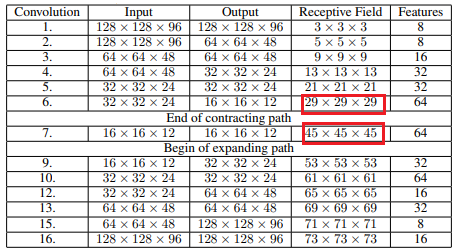

In [33]:
rf_table = cv2.imread('/content/Table.png')
cv2_imshow( rf_table)

In the same page, the model is shown as below:

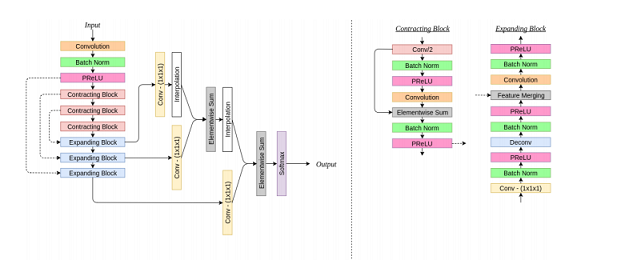

In [35]:
model = cv2.imread('/content/Model.png')
cv2_imshow( model)

Model have one convolution block followed by three Contracting blocks. And it is also observed each Contractin block have one convolution with Strides of 2 followed by normal convolution.

So using the formulas for Rout = rin + (K-1) * Jin and Jout = Jin * S, we can observe the jump in receptive field from 29 to 45 as shown below

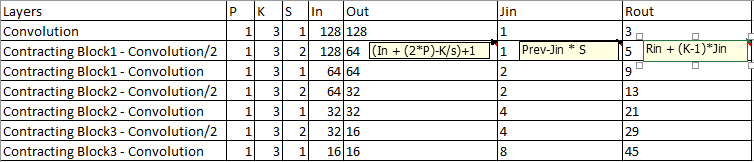

In [5]:
from google.colab.patches import cv2_imshow
rf_calculation = cv2.imread('/content/RF_Calculation.png')
cv2_imshow( rf_calculation)